### Goal
- Input: RGB image.
- Teacher: Depth Anything V2 → predicts a high-quality depth map.
- Student: A smaller, faster model → learns to mimic the teacher’s depth map predictions.

In [ ]:
import torch
from torch import nn

import torchvision
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm.auto import tqdm
from timeit import default_timer as timer
import random

from SegNet import SegNet


In [ ]:
class DepthDataset(torch.utils.data.Dataset):
    def __init__(self, images_dir, depth_maps_dir, transform=None):
        self.images_dir = images_dir
        self.depth_maps_dir = depth_maps_dir
        self.transform = transform

        self.files = [f for f in os.listdir(images_dir) if f.lower().endswith('.png')]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_dir, self.files[idx])
        depth_map_path = os.path.join(self.depth_maps_dir, self.files[idx])

        image = plt.imread(image_path)
        depth_map = plt.imread(depth_map_path)[:,:,0]

        if self.transform:
            image = self.transform(image)
            depth_map = self.transform(depth_map)

        return image, depth_map

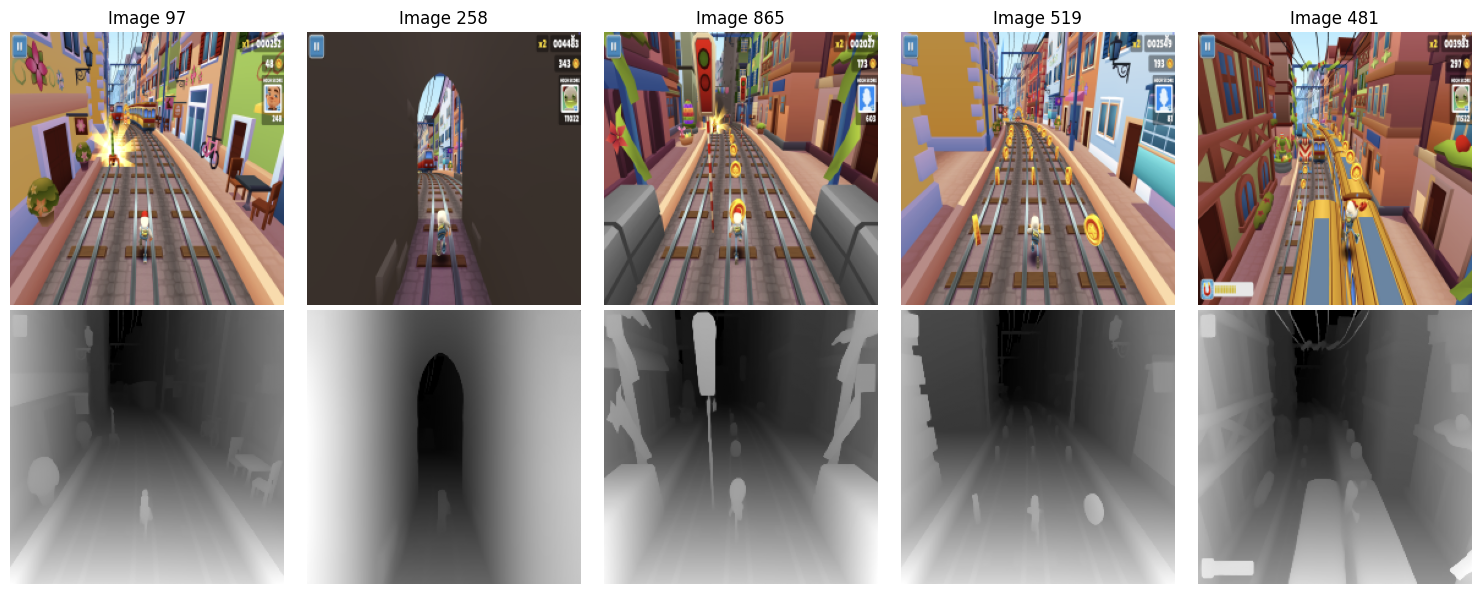

In [11]:
dataset = DepthDataset(
    images_dir='data/depth_data/images',
    depth_maps_dir='data/depth_data/depth_maps',
    transform=ToTensor(),
)

# Create a figure with 2 rows and 5 columns
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Get 5 random samples from the dataset
indices = np.random.choice(len(dataset), 5, replace=False)

for i, idx in enumerate(indices):
    # Get image and depth map
    image, depth_map = dataset[idx]

    # Convert tensors back to numpy for plotting
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).numpy()
    if isinstance(depth_map, torch.Tensor):
        depth_map = depth_map.numpy().squeeze()

    # Plot RGB image in first row
    axes[0, i].imshow(image)
    axes[0, i].set_title(f'Image {idx}')
    axes[0, i].axis('off')

    # Plot depth map in second row
    axes[1, i].imshow(depth_map, cmap='gray')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


In [12]:
torch.manual_seed(42)
train, val, test = torch.utils.data.random_split(dataset, [0.7, 0.15, 0.15])
train.__len__(), val.__len__(), test.__len__()

(658, 141, 141)

In [13]:
train_loader = torch.utils.data.DataLoader(train, batch_size=4, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=4, shuffle=False)
test_loader = torch.utils.data.DataLoader(test, batch_size=4, shuffle=False)

images, depth_maps = next(iter(train_loader))
print(f'Batch of images shape: {images.shape}')
print(f'Batch of depth maps shape: {depth_maps.shape}')

Batch of images shape: torch.Size([4, 3, 224, 224])
Batch of depth maps shape: torch.Size([4, 1, 224, 224])


Sorce: https://arxiv.org/pdf/1406.2283

In [ ]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SegNet(in_channels=3, out_channels=1).to(device)

In [15]:
# Replace CrossEntropyLoss with MSELoss for depth estimation
loss_fn = nn.MSELoss()  # Use MSE for regression tasks
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
# Fix 1: Move data to device and ensure correct data types
torch.manual_seed(42)
train_time_start_on_cpu = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch + 1} \n------------')
    # Training loop
    train_loss = 0.0
    for batch, (X, y) in enumerate(train_loader):
        # Move data to device and ensure float32
        X = X.to(device).float()
        y = y.to(device).float()

        model.train()
        y_pred = model(X)
        loss = loss_fn(y_pred, y)  # Fix: pass y to loss function
        train_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 40 == 0:
            print(f'Loss: {loss.item():.5f} | Batch: {batch + 1}/{len(train_loader)}')

    train_loss /= len(train_loader)

    # Testing loop
    test_loss, test_acc = 0.0, 0.0
    model.eval()
    with torch.inference_mode():
        for X_test, y_test in test_loader:
            # Move test data to device
            X_test = X_test.to(device).float()
            y_test = y_test.to(device).float()

            y_pred = model(X_test)
            loss = loss_fn(y_pred, y_test)
            test_loss += loss
            test_acc += (y_pred.squeeze() - y_test).abs().mean().item()

        test_loss /= len(test_loader)
        test_acc /= len(test_loader)

    print(f'Train Loss: {train_loss:.5f} | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.5f}')
    print('-----------------------------------')

train_time_end_on_cpu = timer()
total_train_time = train_time_end_on_cpu - train_time_start_on_cpu
print(f'Total training time on CPU: {total_train_time:.2f} seconds')

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1 
------------
Loss: 0.02974 | Batch: 1/165
Loss: 0.04641 | Batch: 41/165
Loss: 0.03543 | Batch: 81/165
Loss: 0.02078 | Batch: 121/165
Loss: 0.01711 | Batch: 161/165
Train Loss: 0.03033 | Test Loss: 0.02523 | Test Acc: 0.14256
-----------------------------------
Epoch: 2 
------------
Loss: 0.02735 | Batch: 1/165
Loss: 0.02417 | Batch: 41/165
Loss: 0.01838 | Batch: 81/165
Loss: 0.02134 | Batch: 121/165
Loss: 0.01646 | Batch: 161/165
Train Loss: 0.02843 | Test Loss: 0.02707 | Test Acc: 0.14549
-----------------------------------
Epoch: 3 
------------
Loss: 0.02425 | Batch: 1/165
Loss: 0.01674 | Batch: 41/165
Loss: 0.02756 | Batch: 81/165
Loss: 0.02240 | Batch: 121/165
Loss: 0.02199 | Batch: 161/165
Train Loss: 0.02559 | Test Loss: 0.02121 | Test Acc: 0.13964
-----------------------------------
Total training time on CPU: 90.20 seconds


In [ ]:
# torch.save(model.state_dict(), 'model_weights.pth')

In [ ]:
# model = SegNet(in_channels=3, out_channels=1).to(device)
# model.load_state_dict(torch.load('model_weights.pth'))

In [18]:
def make_predictions(
    model: torch.nn.Module,
    data: list,
    device=device
):
    model.to(device)
    model.eval()
    predictions = []
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)
            pred = model(sample)
            pred = pred.squeeze()
            predictions.append(pred)

    return predictions

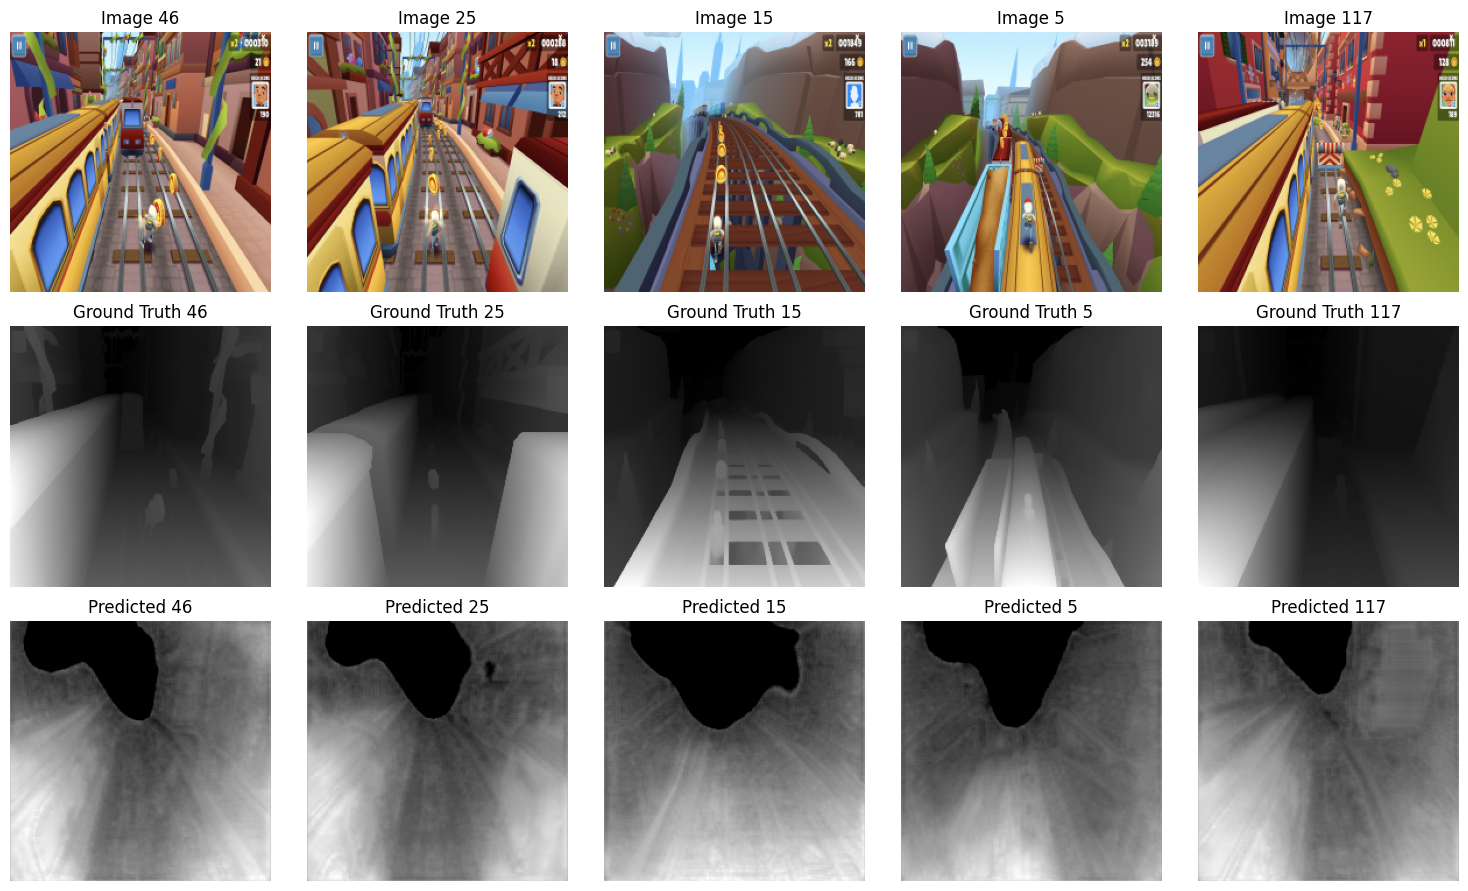

In [19]:
samples = random.sample(range(len(test)), 5)
predictions = make_predictions(model, [test[i][0] for i in samples])

# Show original image, ground truth depth, and predicted depth
fig, axes = plt.subplots(3, 5, figsize=(15, 9))

for i, idx in enumerate(samples):
    image, depth_map = test[idx]
    pred = predictions[i].cpu().numpy()

    # Convert tensors back to numpy for plotting
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).numpy()
    if isinstance(depth_map, torch.Tensor):
        depth_map = depth_map.numpy().squeeze()

    # Row 1: Original images
    axes[0, i].imshow(image)
    axes[0, i].set_title(f'Image {idx}')
    axes[0, i].axis('off')

    # Row 2: Ground truth depth maps
    axes[1, i].imshow(depth_map, cmap='gray')
    axes[1, i].set_title(f'Ground Truth {idx}')
    axes[1, i].axis('off')

    # Row 3: Predicted depth maps
    axes[2, i].imshow(pred, cmap='gray')
    axes[2, i].set_title(f'Predicted {idx}')
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()

In [20]:
_, depth_map = test[0]
depth_map, depth_map.squeeze().shape

(tensor([[[0.3804, 0.3804, 0.3804,  ..., 0.1176, 0.1176, 0.1059],
          [0.3804, 0.3804, 0.3804,  ..., 0.1176, 0.1176, 0.1176],
          [0.3804, 0.3804, 0.3765,  ..., 0.1176, 0.1176, 0.1176],
          ...,
          [0.3176, 0.3137, 0.3137,  ..., 0.9804, 0.9882, 0.9961],
          [0.3176, 0.3137, 0.3137,  ..., 0.9804, 0.9882, 0.9922],
          [0.3176, 0.3137, 0.3098,  ..., 0.9804, 0.9882, 1.0000]]]),
 torch.Size([224, 224]))

In [21]:
pred = predictions[0]
pred, pred.shape

(tensor([[0.3493, 0.2768, 0.2708,  ..., 0.3666, 0.3706, 0.3968],
         [0.3228, 0.2654, 0.2462,  ..., 0.4016, 0.4203, 0.4408],
         [0.3079, 0.2398, 0.2185,  ..., 0.4126, 0.4256, 0.4541],
         ...,
         [0.6218, 0.6840, 0.6944,  ..., 0.7169, 0.7055, 0.6444],
         [0.6216, 0.6882, 0.6954,  ..., 0.7178, 0.7028, 0.6455],
         [0.5817, 0.6616, 0.6704,  ..., 0.6952, 0.6904, 0.6145]],
        device='cuda:0'),
 torch.Size([224, 224]))